In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch as pt 

import sys
import os
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../'))

from src.useful_functions import *
from src.modules2_2 import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)

Created variables:
inp_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/input/
dcd_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/output/trajectories/openmm_files
out_dir = /scratch/htc/fsafarov/ISOKANN_PINN/output/

cuda


In [2]:
# Get the tensor for clustering the state space

from src.clustering_metrics import*

#Atom names are deriven from pymol, we can get them from mdtraj as well

ligand_F = "resname KB8 and name F*"



pdbfile_water    = 'pdbfile_water.pdb' 
file_traj_water  = 'trajectory_water_combined6.dcd'
out_file='CF3_coords.pt'
# get_coords(
#                                     ligand_F,
#                                     inp_dir=inp_dir, 
#                                     pdb_file=pdbfile_water, 
#                                     traj_dir=dcd_dir, 
#                                     traj_file=file_traj_water, 
#                                     distances_dir=out_dir, 
#                                     out_file=out_file
#                                   )


In [3]:
frame = 0

# Load initial and final states 
pdbfile_water    = 'pdbfile_water.pdb' 
file_traj_water  = 'trajectory_water_combined6.dcd'

mdtraj =  md.load( os.path.join(dcd_dir, file_traj_water), top =os.path.join(inp_dir, pdbfile_water)).remove_solvent() 
#atoms_BB = mdtraj.topology.select("backbone")
#mdtraj = mdtraj.atom_slice(atoms_BB)

X0     = pt.load(os.path.join(out_dir, out_file), map_location=device).cpu().detach().numpy()         #  X0.shape = (N, 1) 

# Load chi function
chi0 = np.loadtxt(os.path.join(out_dir, 'chi_0.txt'))     #  chi0.shape = (Npoints,)

data           =  OrganizeData( X0, chi0, MDtraj = mdtraj)

FIs    =  FindIntervals(data, Nintervals=5, clustering = 'grid')

Check shape of input data
X0.shape   =  (6000, 3, 3)
chi0.shape =  (6000,)
  


In [4]:
FNs    =  FindNodes(data, FIs,  
                                eps   = [0.3, 0.25, 0.2, 0.17, 0.3],
                                theta = [5,      5,   5, 5, 5,], 
                                algorithm = 'CNNC', 
                                metric = 'mdtraj_rmsd') 
print(np.sum(FNs.nodes==-1))

print("Number of nodes:", str(FNs.Nnodes))
for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])

100%|██████████| 5/5 [00:47<00:00,  9.56s/it]


0
Number of nodes: 37
Node, interval, size: 0 0 3415
Node, interval, size: 1 0 15
Node, interval, size: 2 1 116
Node, interval, size: 3 1 10
Node, interval, size: 4 1 175
Node, interval, size: 5 1 2
Node, interval, size: 6 1 2
Node, interval, size: 7 1 5
Node, interval, size: 8 1 2
Node, interval, size: 9 1 22
Node, interval, size: 10 1 116
Node, interval, size: 11 2 7
Node, interval, size: 12 2 6
Node, interval, size: 13 2 2
Node, interval, size: 14 2 2
Node, interval, size: 15 2 13
Node, interval, size: 16 2 2
Node, interval, size: 17 2 3
Node, interval, size: 18 2 5
Node, interval, size: 19 2 2
Node, interval, size: 20 2 3
Node, interval, size: 21 2 8
Node, interval, size: 22 2 7
Node, interval, size: 23 2 40
Node, interval, size: 24 2 6
Node, interval, size: 25 2 2
Node, interval, size: 26 2 2
Node, interval, size: 27 2 2
Node, interval, size: 28 2 2
Node, interval, size: 29 2 2
Node, interval, size: 30 2 2
Node, interval, size: 31 2 2
Node, interval, size: 32 2 1023
Node, interval

In [5]:
#BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=128, threshold =113,algorithm='mlp')
BAM    =  BuildAdjacencyMatrix(data, FNs, FIs, metric = 'mdtraj_rmsd', include_same_interval=False, r_neighbors = 0.2)


BG     =  BuildGraph(FNs, BAM)
CE     =  CalculateEnergy(FNs)



Text(0.5, 1.0, '(b) Energy')

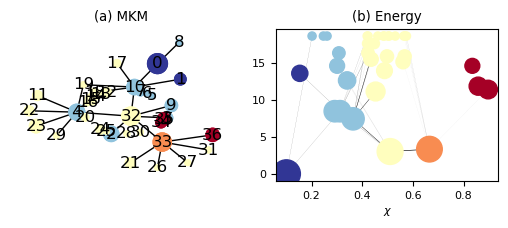

In [6]:
#posG = nx.kamada_kawai_layout(Gd)  # kamada_kawai_layout
#Make graph and nice plots

G      =  BG.G
posG = nx.kamada_kawai_layout(G, center=[0,0])  # kamada_kawai_layout

index_chi_node = FNs.index_chi_node
nodes_size     = np.log(FNs.nodes_size)*50

energy         = CE.energy
P              = BAM.P



font = {'size'   : 8}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16*in2cm, 5*in2cm), facecolor='white')

nx.draw(G, 
        posG, 
        with_labels=True, 
        node_color=index_chi_node, 
        cmap = cm.RdYlBu_r, 
        node_size= nodes_size*0.5,
        edge_color='k', 
        width=1,
        ax=ax1
       )


nx.draw_networkx_nodes(G, 
                       posG, 
                       node_size=nodes_size*0.5,
                       node_color=index_chi_node, 
                       cmap = cm.RdYlBu_r, 
                       ax=ax1)

ax1.set_title('(a) MKM')

################## PLOT ENERGY
chi_nodes = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False).ravel()


for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if BAM.A[i,j]>0:
            ax2.plot([chi_nodes[i], chi_nodes[j]], [energy[i], energy[j]], 'k-', linewidth = np.log(1+5*BAM.C[i,j]),zorder=-1) 



ax2.scatter(chi_nodes, energy, s = nodes_size, c = index_chi_node, cmap = cm.RdYlBu_r)

ax2.set_xlabel(r'$\chi$')
ax2.set_title('(b) Energy')

#plt.subplots_adjust(left=0, bottom=0.0, right=1, top=0.99, wspace=0.0, hspace=0.0)

# fig.savefig("output/figures/mokito.png", format='png', dpi=300, bbox_inches='tight')


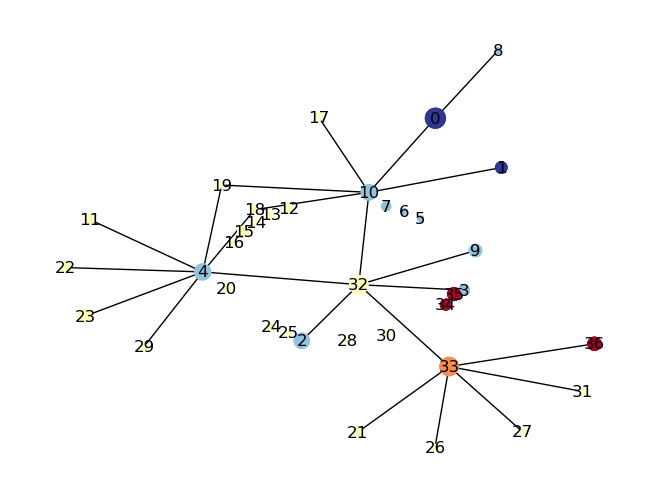

In [7]:
G      =  BG.G
posG = nx.kamada_kawai_layout(G, center=[0,0])  # kamada_kawai_layout
nx.draw(G, 
        posG, 
        with_labels=True, 
        node_color=index_chi_node, 
        cmap = cm.RdYlBu_r, 
        node_size= nodes_size*0.5,
        edge_color='k', 
        width=1,
       )


nx.draw_networkx_nodes(G, 
                       posG, 
                       node_size=nodes_size*0.5,
                       node_color=index_chi_node, 
                       cmap = cm.RdYlBu_r, 
                       )

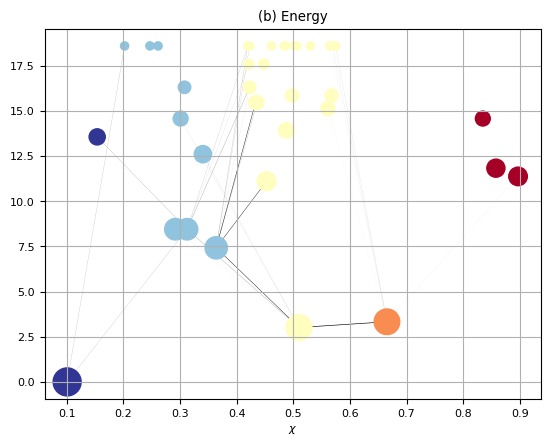

In [8]:
for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if BAM.A[i,j]>0:
            plt.plot([chi_nodes[i], chi_nodes[j]], [energy[i], energy[j]], 'k-', linewidth = np.log(1+5*BAM.C[i,j]),zorder=-1) 



plt.scatter(chi_nodes, energy, s = nodes_size, c = index_chi_node, cmap = cm.RdYlBu_r)

plt.xlabel(r'$\chi$')
plt.title('(b) Energy')
plt.grid()

In [9]:
from dash import Dash, dcc, html, Input, Output, callback
import plotly.graph_objects as go
import py3Dmol as pm
import random
import MDAnalysis as mda



In [10]:
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = posG[edge[0]]
    x1, y1 = posG[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

node_x, node_y = [], []
for node in G.nodes():
    x, y = posG[node]
    node_x.append(x)
    node_y.append(y)

In [11]:
cluster_frame = {}

for i in np.unique(FNs.nodes):
    cluster_frame[int(i)] = np.where(FNs.nodes == i)[0]


In [12]:
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    marker=dict(
        size=12,
        color=index_chi_node,
        colorscale='RdYlBu',
        colorbar=dict(title="Clusters"),
    ),
    hoverinfo='text',
    text=[f"Cluster {i}<br>Frame: {cluster_frame[i]}" for i in G.nodes()], 
    customdata=[cluster_frame[i] for i in G.nodes()],  # IMPORTANT
)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

node_trace.marker.color = index_chi_node

node_trace.marker.size = 0.05*nodes_size

In [13]:
u = mda.Universe("/scratch/htc/fsafarov/2cm2_simulation/md2/input/pdbfile_water.pdb", 
                "/scratch/htc/fsafarov/2cm2_simulation/md2/output/trajectories/openmm_files/trajectory_water_combined6.dcd")

ligand = u.select_atoms('resname KB8')

for ts in u.trajectory:
    ligand.unwrap(compound='fragments')



/scratch/htc/fsafarov/conda/envs/mokito_env/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:295: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/scratch/htc/fsafarov/conda/envs/mokito_env/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [14]:
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=800,
        height=600,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=0)
    )
)

In [15]:
app = Dash()

app.layout = html.Div([
    dcc.Graph(id="network-graph", figure=fig),
    html.Div(id="frame-dropdown-container"),
    html.Div(id="mol3d")
])


In [16]:
@callback(
    Output("frame-dropdown-container", "children"),
    Input("network-graph", "clickData"),
    prevent_initial_call=True
)
def update_dropdown(clickData):
    if clickData is None:
        return "Click a node"

    # Extract frames from customdata
    frames = clickData["points"][0]["customdata"]

    return dcc.Dropdown(
        id="frame-dropdown",
        options=[{"label": f"Frame {f}", "value": f} for f in frames],
        placeholder="Select a frame",
        style={"width": "300px", "margin-top": "10px"}
    )


In [17]:
@callback(
    Output("mol3d", "children", allow_duplicate=True),
    Input("frame-dropdown", "value"),
    prevent_initial_call=True
)
def show_frame(frame):

    if frame is None:
        return "Select a frame"

    # -----------------------------------------------------------
    # LOAD THE FRAME
    # Replace this with MDAnalysis code:
    # u.trajectory[frame]
    # pdb_data = u.atoms.write(stdout=True)
    fname = f"/tmp/frame_{frame}.pdb"
    u.trajectory[frame]
    u.atoms.write(fname)
    with open(fname) as f:
        pdb_data = f.read()
    # -----------------------------------------------------------

    # -----------------------------------------------------------

    # Render py3Dmol view
    view = pm.view(width=600, height=450)
    view.addModel(pdb_data, "pdb")
    view.setStyle({"cartoon": {"color": "spectrum"}})
    view.setStyle({"resn": "KB8"}, {"sphere": {"color": "yellow", "radius": 1.5}})
    
    view.zoomTo()

    return html.Div([
        html.H4(f"Frame {frame}"),
        html.Iframe(
            srcDoc=view._make_html(),
            width="620",
            height="480",
            style={"border": "none"},
        )
    ])


In [ ]:
# ---------------------------------------------------------------------
# RUN APP in EXTERNAL BROWSER TAB
# ---------------------------------------------------------------------
if __name__ == "__main__":
    app.run(
        jupyter_mode="external",       # IMPORTANT: opens in new browser tab
        debug=True,
        host="0.0.0.0",
        port=8890
    )


Dash app running on http://0.0.0.0:8890/


/scratch/htc/fsafarov/conda/envs/mokito_env/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning:

Found no information for attr: 'formalcharges' Using default value of '0'

